In [3]:
import gym
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import random
import matplotlib.pyplot as plt
import requests
import numpy as np

In [4]:
class Replaybuffer:
    def __init__(self,n_state,n_action, batchsize):
        self.n_state = n_state
        self.n_action = n_action
        self.size = 2000 #记忆池大小
        self.batchsize = batchsize

        #给记忆五元组申请空间
        self.s = np.empty(shape = (self.size, self.n_state), dtype=np.float32)
        self.a = np.random.randint(low=0, high=n_action, size=self.size, dtype=np.uint8)
        self.r = np.empty(self.size, dtype=np.float32)
        self.done = np.random.randint(low=0, high=2, size=self.size, dtype=np.uint8)
        self.s_ = np.empty(shape = (self.size, self.n_state), dtype=np.float32)

        self.t = 0
        self.tmax = 0  # 初始化tmax属性 ##后加

    def add_memo(self,s,a,r,done,s_): #需要实现功能：1.交互后增加记忆 2.sample batch时取出记忆
    #第t步向记忆池里加记忆
        #print("s:", s.shape)  # 打印s的形状
        #print("Expected s shape:", (self.n_state,))
        self.s[self.t] = s
        self.a[self.t] = a
        self.r[self.t] = r
        self.done[self.t] = done
        self.s_[self.t] = s_
        self.t = self.t + 1 if self.t + 1 < self.size else 1 #t到2001时，重新从1开始加
        self.tmax = max(self.tmax, self.t +1)



    def sample(self):
    #采样逻辑：Buffer里的经验如果比batchsize多，那就sample;如果比batchsize少，那就有几个取几个
        '''if self.tmax > self.size:
            idxes = random.sample(range(0, self.tmax),self.size)
        else:
            idxes = random.sample(range(0, self.tmax))'''

        if self.tmax > self.batchsize:
           k = self.batchsize  # 如果缓冲区样本数大于等于批次大小，使用批次大小
        else:
           k = self.tmax  # 否则，使用缓冲区的实际样本数量

        idxes = random.sample(range(0, self.tmax), k)  # 使用确定的k值抽样

        batch_s = []
        batch_a = []
        batch_r = []
        batch_done = []
        batch_s_ = []

        for idx in idxes: #抽64个数据
            batch_s.append(self.s[idx])
            batch_a.append(self.a[idx])
            batch_r.append(self.r[idx])
            batch_done.append(self.done[idx])
            batch_s_.append(self.s_[idx])

        #把numpy转换成torch的tensor
        batch_s = torch.as_tensor(np.asarray(batch_s),dtype=torch.float32)
        batch_a = torch.as_tensor(np.asarray(batch_a),dtype=torch.int64).unsqueeze(-1) #升维：从(2)升到(2,1)
        batch_r = torch.as_tensor(np.asarray(batch_r),dtype=torch.float32).unsqueeze(-1)
        batch_done = torch.as_tensor(np.asarray(batch_done),dtype=torch.float32).unsqueeze(-1)
        batch_s_ = torch.as_tensor(np.asarray(batch_s_),dtype=torch.float32)

        return batch_s, batch_a, batch_r, batch_done, batch_s_

In [23]:
class Qnetwork(nn.Module):
      def __init__(self, n_input, n_output):
          super().__init__() #继承Module父类

          self.net = nn.Sequential(
              nn.Linear(in_features= n_input, out_features = 128),
              nn.ReLU(), #nn.Tanh(),
              nn.Linear(in_features= 128, out_features = n_output))

      def forward(self,x):
           return self.net(x) #前向传播

      def act(self,obs, temp): #面对s，找到最大的Q值（因为神经网络输出的不只是最大Q值），输出对应的action
          obs_tensor = torch.as_tensor(obs, dtype=torch.float32)
          q_value = self(obs_tensor.unsqueeze(0)) #转化成行向量

          softmax_output = F.softmax(q_value/temp, dim = 1)
          action_probs = torch.distributions.Categorical(softmax_output)
          action = action_probs.sample().item()
          return action

#Agent with Replay Buffer and Target Network
class Agent:
   def __init__(self, n_input, n_output,  batchsize, Gamma=0.97, learning_rate = 0.01):
            self.n_input = n_input
            self.n_output = n_output
            self.learning_rate = learning_rate
            self.Gamma = Gamma
            self.batchsize = batchsize
            self.memo = Replaybuffer(self.n_input, self.n_output, self.batchsize) #先实例化Agent，得到memo，Memo再实例化Replaybuffer

            #两个网络结构相同，可以用同一个类实例化
            self.online_net = Qnetwork(self.n_input, self.n_output)
            self.target_net = Qnetwork(self.n_input, self.n_output)

            self.optimizer = torch.optim.Adam(self.online_net.parameters(),lr=self.learning_rate)

In [24]:
def run(env, agent, n_step, n_episode, temp):
  s = env.reset()
  episode_array = []
  rewards_array = []
  Reward_list = np.empty(shape=n_episode)

  for episode in range(n_episode):
    epi_reward = 0
    for step in range(n_step):

        a = agent.online_net.act(s, temp) #todo


        s_, r, done, _ = env.step(a) #执行动作a，得到s_,r,done,info
        agent.memo.add_memo(s, a, r, done, s_) #添加经验到exp buffer里
        s = s_ #store transition
        epi_reward += r
        #print(epi_reward)

        if done:
           s = env.reset()
           Reward_list[episode] = epi_reward #记录这个episode的总奖励
           break

        '''Sample minibatches from the transition'''
        batch_s, batch_a, batch_r, batch_done, batch_s_ = agent.memo.sample()

        '''Compute Q_target'''
        target_q_values = agent.target_net(batch_s_)
        target_q = batch_r + agent.Gamma * (1-batch_done) * target_q_values.max(dim=1, keepdim=True)[0]
        '''Compute Q_pred'''
        pred_q_values = agent.online_net(batch_s) #对于批处理中的每个状态，它都会给出每个动作的Q值
        pred_q = torch.gather(input=pred_q_values, dim=1, index=batch_a)
        #跟据batch_a中指定的动作索引，从每个状态的动作Q值pred_q_values中选择对应动作的
        '''Compute Loss, gredient descent'''
        loss = nn.functional.smooth_l1_loss(target_q, pred_q)
        agent.optimizer.zero_grad()
        loss.backward()
        agent.optimizer.step() #根据梯度进行下降

        '''Fix Q-target'''
    if episode % TARGET_UPDATE ==0:
        agent.target_net.load_state_dict(agent.online_net.state_dict())
        reward = np.mean(Reward_list[episode-10:episode])
        print("Episode:{}".format(episode))
        print("Reward:{}".format(reward))
        episode_array.append(episode)
        rewards_array.append(reward)

  return episode_array, rewards_array

In [25]:

# Parameters
env_name = "CartPole-v1"
env = gym.make(env_name)
n_input = env.observation_space.shape[0]
n_output = env.action_space.n

n_episode = 1000
n_step = 200
gamma = 0.97
TARGET_UPDATE = 10

temp = 0.01

# Initialize agent for temp = 0.01
agent = Agent(n_input, n_output, 64)
e_array, r_array = run(env, agent, n_step, n_episode, temp)
env.close()

temp = 0.1

# Initialize agent for temp = 0.1
agent = Agent(n_input, n_output, 64)

e1_array, r1_array = run(env, agent, n_step, n_episode, temp)

env.close()


temp = 1

# Initialize agent for temp = 1
agent = Agent(n_input, n_output, 64)

e2_array, r2_array = run(env, agent, n_step, n_episode, temp)

env.close()


temp = 5
# Initialize agent for temp = 5
agent = Agent(n_input, n_output, 64)

e3_array, r3_array = run(env, agent, n_step, n_episode, temp)

env.close()


temp = 10
# Initialize agent for temp = 10
agent = Agent(n_input, n_output, 64)
e4_array, r4_array = run(env, agent, n_step, n_episode, temp)

env.close()


Episode:0
Reward:nan
Episode:10
Reward:9.6
Episode:20
Reward:9.3
Episode:30
Reward:8.9
Episode:40
Reward:9.6
Episode:50
Reward:9.5
Episode:60
Reward:9.2
Episode:70
Reward:9.2
Episode:80
Reward:9.0
Episode:90
Reward:9.5
Episode:100
Reward:9.4
Episode:110
Reward:9.2
Episode:120
Reward:9.5
Episode:130
Reward:9.3
Episode:140
Reward:9.3
Episode:150
Reward:9.3
Episode:160
Reward:9.1
Episode:170
Reward:9.1
Episode:180
Reward:9.6
Episode:190
Reward:9.2
Episode:200
Reward:9.0
Episode:210
Reward:8.9
Episode:220
Reward:9.4
Episode:230
Reward:9.4
Episode:240
Reward:9.3
Episode:250
Reward:8.9
Episode:260
Reward:9.5
Episode:270
Reward:9.4
Episode:280
Reward:9.2
Episode:290
Reward:9.5
Episode:300
Reward:9.2
Episode:310
Reward:9.3
Episode:320
Reward:9.3
Episode:330
Reward:9.3
Episode:340
Reward:9.4
Episode:350
Reward:9.5
Episode:360
Reward:9.1
Episode:370
Reward:9.1
Episode:380
Reward:9.5
Episode:390
Reward:9.3
Episode:400
Reward:8.9
Episode:410
Reward:9.6
Episode:420
Reward:9.5
Episode:430
Reward:9.5

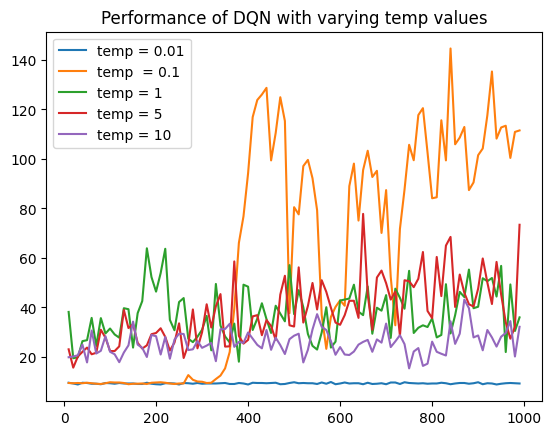

In [26]:
plt.title("Performance of DQN with varying temp values")
plt.plot(e_array, r_array, label = "temp = 0.01")
plt.plot(e1_array, r1_array, label = "temp  = 0.1")
plt.plot(e2_array, r2_array, label = "temp = 1")
plt.plot(e3_array, r3_array, label = "temp = 5")
plt.plot(e4_array, r4_array, label = "temp = 10")

plt.legend()
plt.show()